In [1]:
import bnpy
import numpy as np
import os

from matplotlib import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from hmmlearn.hmm import GaussianHMM
from bnpy import HModel
import time
from sklearn.utils import check_random_state
from importlib import reload
from bnpy import plot_hmm
reload(plot_hmm)

<module 'bnpy.plot_hmm' from '/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/plot_hmm.py'>

In [2]:
# load data

results_em = pickle.load(open(r'/Users/david/Documents/mastersCode/bnpy/bnpy/examples/08_mocap6/results_em.pkl', 'rb'))
results_em_bnpy = pickle.load(open(r'/Users/david/Documents/mastersCode/bnpy/bnpy/examples/08_mocap6/results_em_bnpy.pkl', 'rb'))
results_vi_finite = pickle.load(open(r'/Users/david/Documents/mastersCode/bnpy/bnpy/examples/08_mocap6/results_vi_finite.pkl', 'rb'))
results_vi_inf = pickle.load(open(r'/Users/david/Documents/mastersCode/bnpy/bnpy/examples/08_mocap6/results_vi_infinite.pkl', 'rb'))


# check list
 [1] EM HMM
 ll, criteria, time (complete), time (it)
 [2] Finite HMM VI
 ll, criteria, time (complete), eff components, elbo, time (it)
 [3] Infinite HMM VI
 ll, criteria, time (complete), eff components, elbo, time (it)

Results - max test ll
fin vi - 953
inf vi - 947


In [2]:
# helpers

class CVResults:
    def __init__(self, base_components, re_inits):
        self.base_components = base_components
        self.re_inits = re_inits
        # standard
        self.aic = []
        self.bic = []
        self.lls = []
        self.hmmLearns = []
        self.n_components = []
        self.total_time = None,
        self.time_per_component = []

        # VI
        self.elbo = []
        self.bnpys = []

    def update(self, aic=None, bic=None, lls=None, hmmLearn=None, n_components=None, elbo=None,bnpy=None, component_time=None):
        if aic: self.aic.append(aic)
        if bic: self.bic.append(bic)
        if lls: self.lls.append(lls)
        if hmmLearn: self.hmmLearns.append(hmmLearn)
        if n_components: self.n_components.append(n_components)
        if elbo: self.elbo.append(elbo)
        if bnpy: self.bnpys.append(bnpy)
        if component_time: self.time_per_component.append(component_time)

class CurrentBest:
    def __init__(self):
        self.ll = None
        self.hmmLearn = None
        self.elbo = None
        self.bnpy = None
        self.score = None
        self.updated = False

    def update(self, ll=None, hmmLearn=None, elbo=None, bnpy=None):
        self.updated = True
        self.ll = ll
        self.hmmLearn = hmmLearn
        self.elbo = elbo
        self.bnpy = bnpy


In [3]:
hmm_data = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/tests/synthetic_tests/unstructured_hmm_data_20_samples.pkl', 'rb'))

In [4]:
# run em and get aic / bic and cross-validation likelihood
curr_test = hmm_data['test_data']
data_temp = hmm_data['train_data'][0][0]
# ns = np.arange(2,40,1)
# n_inits = np.arange(0,10,1)
ns = np.arange(2,30,1) # np.arange(2,30,1)
n_inits = np.arange(0,2,1)

In [5]:
start_outer = time.time()
cv_index = 0
# np.random.seed(20)
all_lls = {}
results_em = {}
results_per_component = {}
for n in ns:
    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    aic = []
    bic = []
    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_train_concat = np.concatenate(hmm_data['train_data'][cv_index])
        curr_train_lens = [len(train) for train in curr_train]
        curr_val = hmm_data['val_data'][cv_index]
        curr_val_concat = np.concatenate(hmm_data['val_data'][cv_index])
        curr_val_lens = [len(train) for train in curr_val]

        current_best = CurrentBest()
        for i in n_inits:
            total_inits += 1
            d = curr_train_concat.shape[1]
            means_prior = np.zeros(d)
            nu = d + 2
            beta = np.ones(d) * 2
            kappa = 0.0001
            covars_prior = np.ones(d)
            # curr_hmm = GaussianHMM(n_components=n, covariance_type='diag', means_prior=means_prior, means_weight=kappa, covars_prior=beta, covars_weight=nu) #,random_state=20)
            curr_hmm = GaussianHMM(n_components=n, covariance_type='full')
            curr_hmm.fit(curr_train_concat,curr_train_lens)
            ll = curr_hmm.score(curr_val_concat, curr_val_lens)
            lls.append(ll)
            models.append(curr_hmm)
            if not current_best.updated or ll > current_best.ll:
                # print('no comp: ', n,' || n_init: ', i,' || ll: ',ll)
                current_best.update(ll=ll,hmmLearn=curr_hmm)
            aic.append(curr_hmm.aic(curr_train_concat, curr_train_lens))
            bic.append(curr_hmm.bic(curr_train_concat, curr_train_lens))
    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'test': models[best_model].score(np.concatenate(curr_test),[len(train) for train in curr_test]),
        'avg_val': average_score,
        'bic': np.mean(bic),
        'aic': np.mean(aic),
        'time': (end_inner - start_inner)
    }

end_outer = time.time()
results_em['total_time'] = end_outer - start_outer
results_em['components'] = results_per_component
results_em['total_its'] = len(hmm_data['train_data']) * len(n_inits)
results_em['component_list'] = ns
# cv_results_em.total_time = end_outer - start_outer
    # aic_em.append(best_model.aic(np.concatenate(curr_test)))
    # bic_em.append(best_model.bic(np.concatenate(curr_test)))
    # lls_em.append(best_model.score(np.concatenate(curr_test)))
    # lls_em_train.append(best_model.score(np.concatenate(curr_test)))

calculating for n:  2
calculating for n:  3
calculating for n:  4
calculating for n:  5
calculating for n:  6
calculating for n:  7
calculating for n:  8
calculating for n:  9
calculating for n:  10
calculating for n:  11
calculating for n:  12
calculating for n:  13
calculating for n:  14
calculating for n:  15
calculating for n:  16
calculating for n:  17
calculating for n:  18
calculating for n:  19
calculating for n:  20
calculating for n:  21
calculating for n:  22
calculating for n:  23
calculating for n:  24
calculating for n:  25
calculating for n:  26
calculating for n:  27
calculating for n:  28
calculating for n:  29


In [6]:
# print("Writing to pickle file: " + BASENAME + ".pkl")
output = open('results_em' + ".pkl", "wb")
pickle.dump(results_em, output)
output.close()

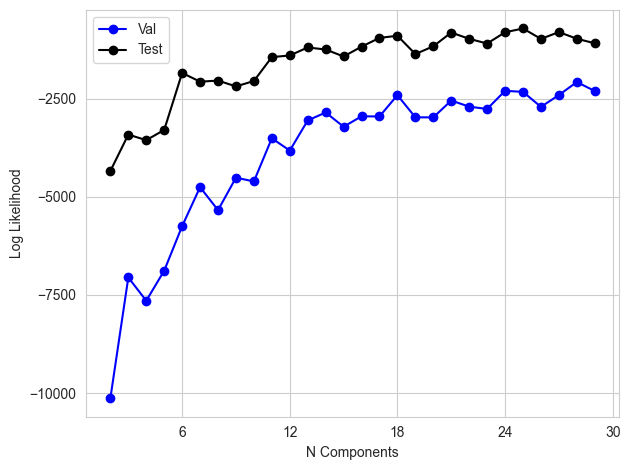

In [8]:
components_results = results_em['components']
fig, ax = plt.subplots()
fig.tight_layout()
avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]

ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')
# Turning off grid lines
# plt.grid(False)

# ax2 = ax.twinx()
# ax2.plot(ns, np.gradient(avg_val_ll), color='darkblue', label='test', marker='o')

ax.set_ylabel("Log Likelihood")
# ax2.set_ylabel("Gradient")
# plt.title('HMM EM Validate/Test')
plt.xlabel('N Components')
# plt.ylabel('Score')
plt.legend()
fig.tight_layout()
plt.show()


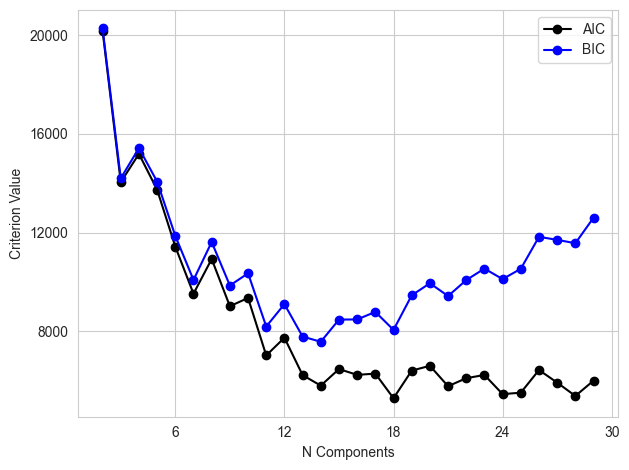

In [7]:
fig, ax = plt.subplots()

bic = [components_results[some_key]['bic'] for some_key in components_results]
aic = [components_results[some_key]['aic'] for some_key in components_results]

ax.plot(ns, aic, color='black', label='AIC', marker='o')
ax.plot(ns, bic, color='blue', label='BIC', marker='o')

# ax2 = ax.twinx()
# ax2.plot(ns, np.gradient(avg_val_ll), color='darkblue', label='test', marker='o')
ax.set_ylabel("log likelihood")
# ax2.set_ylabel("Gradient")
# plt.title('HMM EM AIC/BIC')
plt.xlabel('N Components')
plt.ylabel('Criterion Value')
plt.legend()
fig.tight_layout()
plt.show()


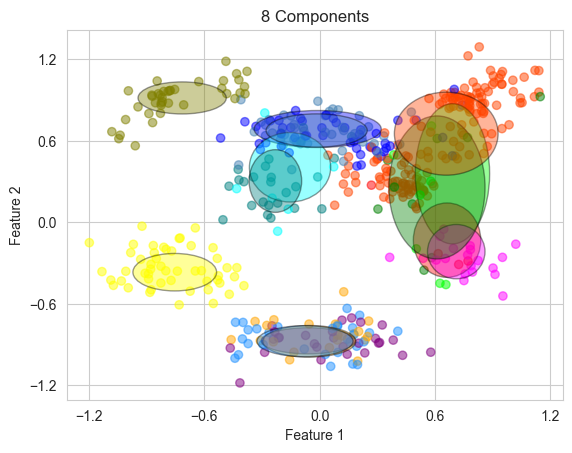

-1213.3245824865096

In [12]:
from bnpy import plot_hmm
reload(plot_hmm)
temp = np.argmax([results_em['components'][some_key]['test'] for some_key in results_em['components']])
hmm_temp = results_em['components'][14]['models'][0]
plot_hmm.plot_hmm_data(curr_test[1], hmm_temp.predict(curr_test[1]), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='8 Components')
hmm_temp.score(np.concatenate(curr_test))

In [24]:
# plt.errorbar(ns, np.gradient(bic), label='BIC')
# plt.errorbar(ns, np.gradient(aic), label='AIC')
# plt.title("Gradient of BIC Scores", fontsize=20)
# # plt.xticks(ns)
# plt.xlabel("N. of clusters")
# plt.ylabel("grad(BIC)")
# plt.legend()
def get_GroupXData_from_list(features_list):
    features_concat = np.vstack(features_list)
    features_len = [0]
    n_doc = 0
    rolling_total = 0

    for i in range(len(features_list)):
        features_len.append(len(features_list[i]) + rolling_total)
        rolling_total += len(features_list[i])
        n_doc += 1

    features_len = np.array(features_len)

    return bnpy.data.GroupXData(X=features_concat, doc_range=features_len,
                                          nDocTotal=n_doc)

def get_hmm_learn_from_bnpy(some_model: HModel):

    obs_model = some_model.obsModel
    total_k = obs_model.K
    means = []
    sigmas = []
    for k in range(total_k):
        sigmas.append(np.diag(obs_model.get_covar_mat_for_comp(k)))
        means.append(obs_model.get_mean_for_comp(k))

    means = np.vstack(means)
    sigmas = np.vstack(sigmas)

    A = some_model.allocModel.get_trans_prob_matrix(),
    pi = some_model.allocModel.get_init_prob_vector(),

    # return A, pi,

    # creat hmm
    hmm_bnpy = GaussianHMM(n_components=len(pi[0]), covariance_type='diag', init_params='')
    hmm_bnpy.n_features = means.shape[1]
    hmm_bnpy.transmat_, hmm_bnpy.startprob_, hmm_bnpy.means_ = normalize_matrix(A[0]), normalize_matrix(pi[0]), means
    hmm_bnpy.covars_ = sigmas
    return hmm_bnpy

def normalize_matrix(matrix):
    matrix += 1e-40
    return matrix / np.sum(matrix, axis=(matrix.ndim - 1), keepdims=True)



In [73]:
start_outer = time.time()
results_em_bnpy = {}
results_per_component = {}
ns = np.arange(2,30,1)
n_inits_v2 = np.arange(0,2,1)

In [74]:
for n in ns:

    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    aic = []
    bic = []
    models_bnpy = []
    elbos = []
    final_components = []

    for cv_index in range(1): # len(hmm_data['train_data'])
        curr_train = hmm_data['train_data'][cv_index]
        curr_train_GroupXData = get_GroupXData_from_list(curr_train)
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits_v2:
            total_inits += 1

            # train and test
            hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
            curr_train_GroupXData, 'FiniteHMM', 'DiagGauss', 'EM',
            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
            nLap=100, nTask=1, nBatch=1, convergeThr=0.0001,
            K=n, initname='randexamples')
            elbo = hmmdiag_info_dict['loss']
            curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            aic.append(curr_hmm.aic(np.concatenate(curr_train + curr_val)))
            bic.append(curr_hmm.bic(np.concatenate(curr_train + curr_val)))
            models_bnpy.append([hmmdiag_trained_model, hmmdiag_info_dict])
            elbos.append(elbo)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'bic': np.mean(bic),
        'aic': np.mean(aic),
        'models_bnpy': models_bnpy,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'elbo': np.mean(elbos),
    }

end_outer = time.time()
results_em_bnpy['total_time'] = end_outer - start_outer
results_em_bnpy['components'] = results_per_component
results_em_bnpy['total_its'] = len(hmm_data['train_data']) * len(n_inits_v2)
results_em_bnpy['component_list'] = ns


calculating for n:  2
  --nBatch
Dataset Summary:
GroupXData
  size: 12 units (documents)
  dimension: 2
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 2  2] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]]
Initialization:
  initname = randexamples
  K = 2 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: EM | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
        1/100 after      0 sec. |    424.7 MiB | K    2 | loss  1.867938733e+07 |  
        2/100 after      0 sec. |    424.7 MiB | K    2 | loss  7.880302236e-01 | Ndiff    5.465 
        3/100 after      0 sec. |    424.7 MiB | K    2 | loss  7.852470655e-01 | Ndiff    9.138 
        4/100 after      0 sec. |    424.7 MiB | K    2 | loss  7.8

In [9]:
output = open('results_em_bnpy' + ".pkl", "wb")
pickle.dump(results_em_bnpy, output)
output.close()

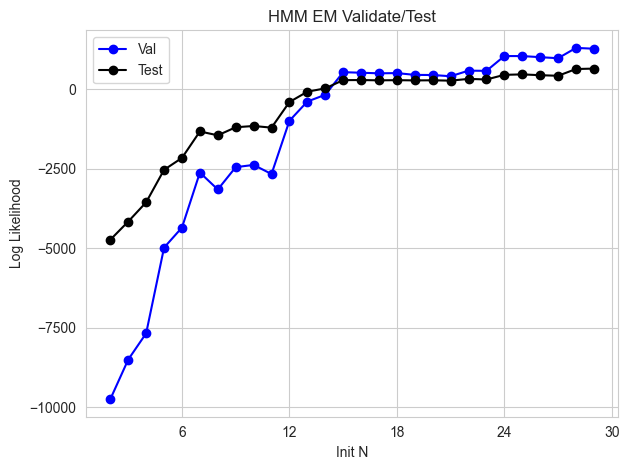

In [257]:
components_results = results_em_bnpy['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
# final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]
elbo = [components_results[some_key]['elbo'] for some_key in components_results]

fig, ax = plt.subplots()

ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns, test_ll, color='black', label='Test', marker='o')

# ax2 = ax.twinx()
# ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
# ax2.set_yticks(np.arange(0,15,1))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Loss', marker='o', color='green')
# ax3.set_ylabel("Loss")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines) # + ax3.lines)
ax.set_title("HMM EM Validate/Test")
ax.set_ylabel("Log Likelihood")
# ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


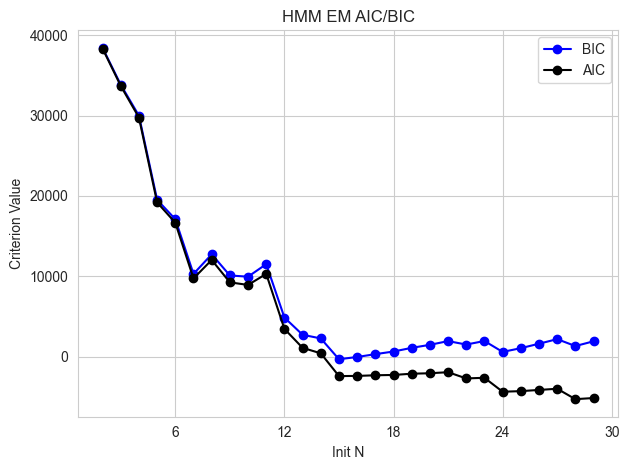

In [270]:
components_results = results_em_bnpy['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

bic = [components_results[some_key]['bic'] for some_key in components_results]
aic = [components_results[some_key]['aic'] for some_key in components_results]
# final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]
# elbo = [components_results[some_key]['elbo'] for some_key in components_results]

fig, ax = plt.subplots()

ax.plot(ns, bic, color='blue', label='BIC', marker='o')
ax.plot(ns, aic, color='black', label='AIC', marker='o')

# ax2 = ax.twinx()
# ax2.plot(ns, final_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
# ax2.set_yticks(np.arange(0,15,1))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Loss', marker='o', color='green')
# ax3.set_ylabel("Loss")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines)
ax.set_title("HMM EM AIC/BIC")
ax.set_ylabel("Criterion Value")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


min elbo VI infinite test value:  -0.35651727844785985 27 524.9194219112396


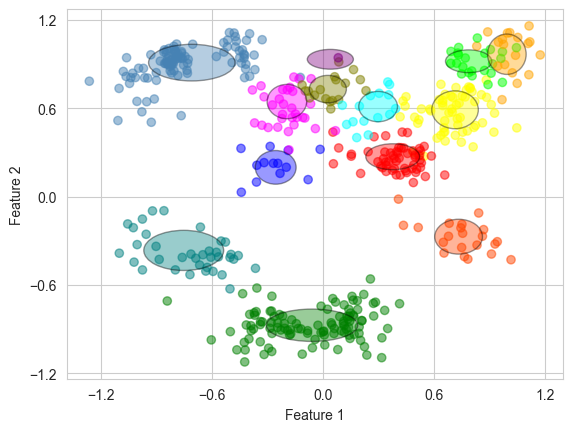

In [275]:
# em bnpy
print('min elbo VI infinite test value: ', np.min([results_em_bnpy['components'][some_key]['elbo'] for some_key in results_em_bnpy['components']]), np.argmin([results_em_bnpy['components'][some_key]['elbo'] for some_key in results_em_bnpy['components']]), results_em_bnpy['total_time'])

hmm_temp = results_em_bnpy['components'][13]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, percent=1, legend=False, title='')

In [26]:
# VI params
alphas = np.array([0.1,1,50,100,500,1000,10000])
ns_alphas = np.arange(len(alphas))
n_inits_v2 = np.arange(0,2,1)
K = 30

In [27]:
transAlpha = 0.05  # trans-level Dirichlet concentration parameter
startAlpha = 2
sF = 1.0          # Set observation model prior so E[covariance] = identity
ECovMat = 'eye'

start_outer = time.time()
results_vi_finite = {}
results_per_component = {}
for n in ns_alphas:
    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    aic = []
    bic = []
    models_bnpy = []
    elbos = []
    final_components = []

    for cv_index in range(1): # len(hmm_data['train_data'])
        curr_train = hmm_data['train_data'][cv_index]
        curr_train_GroupXData = get_GroupXData_from_list(curr_train)
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits_v2:
            total_inits += 1

            # train and test
            hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
            curr_train_GroupXData, 'FiniteHMM', 'DiagGauss', 'memoVB',
            output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
            nLap=50, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=startAlpha,
            transAlpha=alphas[n], hmmKappa=10, sF=sF, ECovMat=ECovMat,
            K=K, initname='randexamples')
            elbo = hmmdiag_info_dict['loss']
            curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            aic.append(curr_hmm.aic(np.concatenate(curr_train + curr_val)))
            bic.append(curr_hmm.bic(np.concatenate(curr_train + curr_val)))
            models_bnpy.append([hmmdiag_trained_model, hmmdiag_info_dict])
            elbos.append(elbo)

            # final components from A matrix
            n_zero_comps = np.sum(np.isclose(np.sum(curr_hmm.means_, axis=1), 0))
            t_comps = curr_hmm.means_.shape[0]
            final_components.append(t_comps - n_zero_comps)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'bic': np.mean(bic),
        'aic': np.mean(aic),
        'models_bnpy': models_bnpy,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'elbo': np.mean(elbos),
        'final_components': final_components,
        'final_components_mean': np.mean(final_components)
    }

end_outer = time.time()
results_vi_finite['total_time'] = end_outer - start_outer
results_vi_finite['components'] = results_per_component
results_vi_finite['total_its'] = len(hmm_data['train_data']) * len(n_inits_v2)
results_vi_finite['component_list'] = ns


calculating for n:  0
Dataset Summary:
GroupXData
  total size: 12 units
  batch size: 12 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 2  2] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]]
Initialization:
  initname = randexamples
  K = 30 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
    1.000/50 after      0 sec. |    350.3 MiB | K   30 | loss  9.200753070e-01 |  
    2.000/50 after      0 sec. |    357.2 MiB | K   30 | loss  6.094328922e-01 | Ndiff  243.916 
    3.000/50 after      1 sec. |    360.7 MiB | K   30 | loss  4.460319756e-01 | Ndiff  163.559 
    4.000/50 after      1 sec. |    360.7 MiB | K   30 |

In [14]:
# print("Writing to pickle file: " + BASENAME + ".pkl")
output = open('results_vi_finite' + ".pkl", "wb")
pickle.dump(results_vi_finite, output)
output.close()

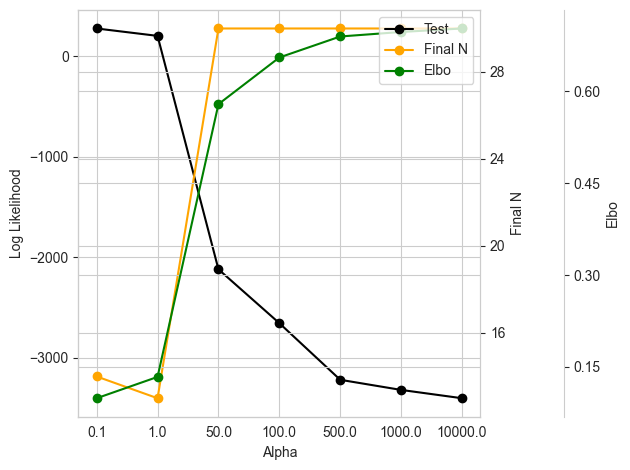

In [65]:
components_results = results_vi_finite['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]
elbo = [components_results[some_key]['elbo'] for some_key in components_results]
argmax =  np.array([np.argmax(components_results[some_key]['lls']) for some_key in components_results])
final_components = np.array([components_results[some_key]['final_components'] for some_key in components_results])
argmax_components = [final_components[i, argmax[i]] for i in range(len(argmax))]

fig, ax = plt.subplots()

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns_alphas, test_ll, color='black', label='Test', marker='o')
ax.set_xticks(ns_alphas, alphas)

ax2 = ax.twinx()
ax2.plot(ns_alphas, argmax_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,35)
# ax2.set_yticks(np.arange(0,35,1))

ax3 = ax.twinx()
ax3.plot(ns_alphas, elbo, label='Elbo', marker='o', color='green')
ax3.set_ylabel("Elbo")
ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines + ax2.lines + ax3.lines)
# ax.set_title("HMM VI Infinite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax2.set_ylabel("Final N")
ax.set_xlabel("Alpha")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


min elbo VI finite test value:  0.09862577613585496 0 132.24572491645813


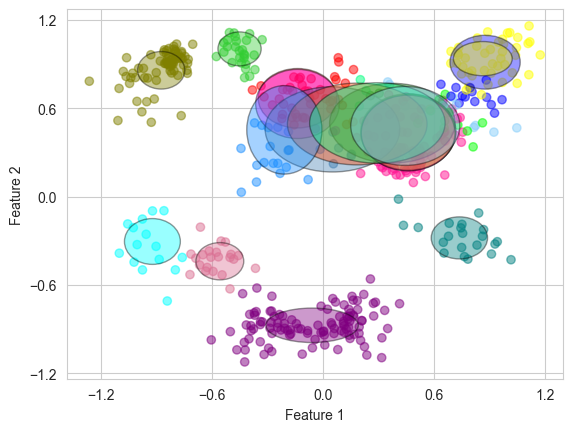

In [70]:
# fin
print('min elbo VI finite test value: ', np.min([results_vi_finite['components'][some_key]['elbo'] for some_key in results_vi_finite['components']]), np.argmin([results_vi_finite['components'][some_key]['elbo'] for some_key in results_vi_finite['components']]), results_vi_finite['total_time'])

hmm_temp = results_vi_finite['components'][3]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, percent=1, legend=False, title='')

In [60]:
# ns_v2 = np.arange(20,35,1)

# K = 40            # Number of clusters/states
gamma = 1000
startAlpha = 10     # top-level Dirichlet concentration parameter
transAlpha = 10  # trans-level Dirichlet concentration parameter
hmmKappa = 10
sF = 1.0          # Set observation model prior so E[covariance] = identity
ECovMat = 'eye'

start_outer = time.time()
results_vi_inf = {}
results_per_component = {}
for n in ns_alphas:
    print('calculating for n: ', n)
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    aic = []
    bic = []
    models_bnpy = []
    elbos = []
    final_components = []

    # for cv_index in range(len(hmm_data['train_data'])):
    # for cv_index in range(0):
    cv_index = 0
    curr_train = hmm_data['train_data'][cv_index]
    curr_train_GroupXData = get_GroupXData_from_list(curr_train)
    curr_val = hmm_data['val_data'][cv_index]

    for i in n_inits_v2:
        total_inits += 1

        # train and test
        hmmdiag_trained_model, hmmdiag_info_dict = bnpy.run(
        curr_train_GroupXData, 'HDPHMM', 'DiagGauss', 'memoVB',
        output_path='/tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/',
        nLap=50, nTask=1, nBatch=1, convergeThr=0.0001, startAlpha=startAlpha,
        transAlpha=transAlpha, gamma=alphas[n], hmmKappa=hmmKappa, sF=sF, ECovMat=ECovMat,
        K=K, initname='randexamples')
        elbo = hmmdiag_info_dict['loss']
        curr_hmm = get_hmm_learn_from_bnpy(hmmdiag_trained_model)
        ll = curr_hmm.score(np.concatenate(curr_val))

        # append
        lls.append(ll)
        models.append(curr_hmm)
        aic.append(curr_hmm.aic(np.concatenate(curr_train + curr_val)))
        bic.append(curr_hmm.bic(np.concatenate(curr_train + curr_val)))
        models_bnpy.append([hmmdiag_trained_model, hmmdiag_info_dict])
        elbos.append(elbo)

        # final components from A matrix
        # zero_rows_in_cols = np.sum(np.isclose(curr_hmm.transmat_, 0), axis=0)
        # diag_alpha = np.diag(curr_hmm.transmat_)
        # min_diag_alpha = np.min(diag_alpha)
        # count_min_diag_alpha = len(np.where(np.isclose(diag_alpha,1.0))[0])
        # n_comps = len(diag_alpha)
        # if count_min_diag_alpha > 1:
        #     n_comps = len(diag_alpha) - count_min_diag_alpha
        n_zero_comps = np.sum(np.isclose(np.sum(curr_hmm.means_, axis=1), 0))
        t_comps = curr_hmm.means_.shape[0]
        final_components.append(t_comps - n_zero_comps)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'bic': np.mean(bic),
        'aic': np.mean(aic),
        'models_bnpy': models_bnpy,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'elbo': np.mean(elbos),
        'final_components': final_components,
        'final_components_mean': np.mean(final_components)
    }
    print('final_components_mean', np.mean(final_components))

end_outer = time.time()
results_vi_inf['total_time'] = end_outer - start_outer
results_vi_inf['components'] = results_per_component
results_vi_inf['total_its'] = len(hmm_data['train_data']) * len(n_inits_v2)
results_vi_inf['component_list'] = ns

calculating for n:  0
Dataset Summary:
GroupXData
  total size: 12 units
  batch size: 12 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 2  2] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]]
Initialization:
  initname = randexamples
  K = 30 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/showcase-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye/1
    1.000/50 after      0 sec. |    416.4 MiB | K   30 | loss  9.731334666e-01 |  
    2.000/50 after      0 sec. |    416.4 MiB | K   30 | loss  6.661627569e-01 | Ndiff  285.293 
    3.000/50 after      1 sec. |    416.4 MiB | K   30 | loss  4.982449107e-01 | Ndiff  189.605 
    4.000/50 after      1 sec. |    416.4 MiB | K   30 |

In [24]:
output = open('results_vi_infinite' + ".pkl", "wb")
pickle.dump(results_vi_inf, output)
output.close()

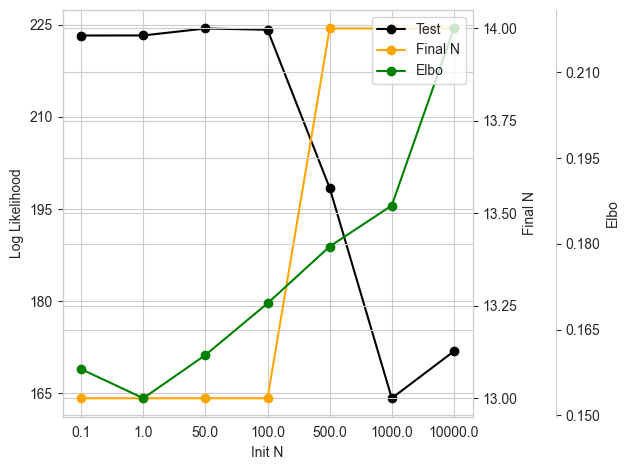

In [66]:
components_results = results_vi_inf['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = [components_results[some_key]['final_components_mean'] for some_key in components_results]
elbo = [components_results[some_key]['elbo'] for some_key in components_results]
argmax =  np.array([np.argmax(components_results[some_key]['lls']) for some_key in components_results])
final_components = np.array([components_results[some_key]['final_components'] for some_key in components_results])
argmax_components = [final_components[i, argmax[i]] for i in range(len(argmax))]

fig, ax = plt.subplots()

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns_alphas, test_ll, color='black', label='Test', marker='o')
ax.set_xticks(ns_alphas, alphas)

ax2 = ax.twinx()
ax2.plot(ns_alphas, argmax_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,35)
# ax2.set_yticks(np.arange(0,35,1))

ax3 = ax.twinx()
ax3.plot(ns_alphas, elbo, label='Elbo', marker='o', color='green')
ax3.set_ylabel("Elbo")
ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines + ax2.lines + ax3.lines)
# ax.set_title("HMM VI Infinite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


min elbo VI infinite test value:  0.15301518685081728 1 139.4298219680786


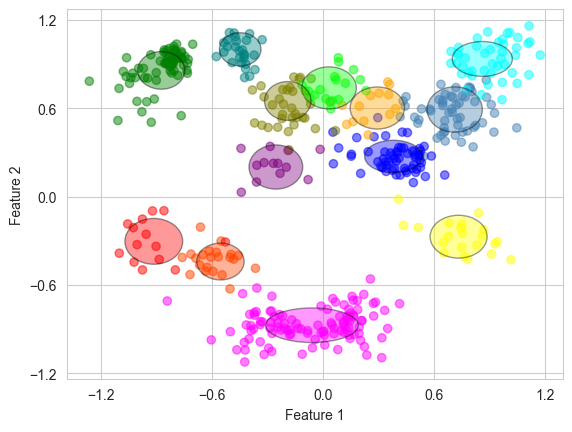

In [69]:
# inf
print('min elbo VI infinite test value: ', np.min([results_vi_inf['components'][some_key]['elbo'] for some_key in results_vi_inf['components']]), np.argmin([results_vi_inf['components'][some_key]['elbo'] for some_key in results_vi_inf['components']]), results_vi_inf['total_time'])

hmm_temp = results_vi_inf['components'][1]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, percent=1, legend=False, title='')

In [268]:
## why is vi so much better than EM ?
from bnpy import plot_hmm
reload(plot_hmm)

print('max EM test value: ', np.max([results_em['components'][some_key]['test'] for some_key in results_em['components']]), (np.argmax([results_em['components'][some_key]['test'] for some_key in results_em['components']])), results_em['total_time'])

NameError: name 'results_em' is not defined

In [24]:
ctemp = np.argmax([results_vi_inf['components'][some_key]['test'] for some_key in results_em['components']])
print(temp)
hmm_temp = results_vi_inf['components'][13+2]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, percent=1, legend=False, title='')omponents_results = results_vi_inf['components']
some_std_avg = np.mean([np.std(components_results[some_key]['lls']) for some_key in components_results], axis=0)

In [32]:
# print('min elbo VI finite test value: ', np.min([results_vi_finite['components'][some_key]['elbo'] for some_key in results_vi_finite['components']]),np.argmin([results_vi_finite['components'][some_key]['elbo'] for some_key in results_vi_finite['components']]), results_vi_finite['total_time'])

print('min elbo VI infinite test value: ', np.min([results_vi_inf['components'][some_key]['elbo'] for some_key in results_vi_inf['components']]), np.argmin([results_vi_inf['components'][some_key]['elbo'] for some_key in results_vi_inf['components']]), results_vi_inf['total_time'])

min elbo VI infinite test value:  0.0950998566606988 32 396.734983921051


In [ ]:

print('max EM bnpy test value: ', np.max([results_em_bnpy['components'][some_key]['test'] for some_key in results_em_bnpy['components']]), (np.argmax([results_em_bnpy['components'][some_key]['test'] for some_key in results_em_bnpy['components']])), results_em_bnpy['total_time'])
print('max VI finite test value: ', np.max([results_vi_finite['components'][some_key]['test'] for some_key in results_vi_finite['components']]),np.argmax([results_vi_finite['components'][some_key]['test'] for some_key in results_vi_finite['components']]), results_vi_finite['total_time'])
print('max VI infinite test value: ', np.max([results_vi_inf['components'][some_key]['test'] for some_key in results_vi_inf['components']]), np.argmax([results_vi_inf['components'][some_key]['test'] for some_key in results_vi_inf['components']]), results_vi_inf['total_time'])

In [23]:

data_temp = hmm_data['train_data'][0][0]

temp = np.argmax([results_em['components'][some_key]['test'] for some_key in results_em['components']])
hmm_temp = results_em['components'][16+2]['models'][1]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='EM Components')

temp = np.argmax([results_em_bnpy['components'][some_key]['test'] for some_key in results_em_bnpy['components']])
hmm_temp = results_em_bnpy['components'][16+2]['models'][1]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='EM bnpy Components')


NameError: name 'results_em' is not defined

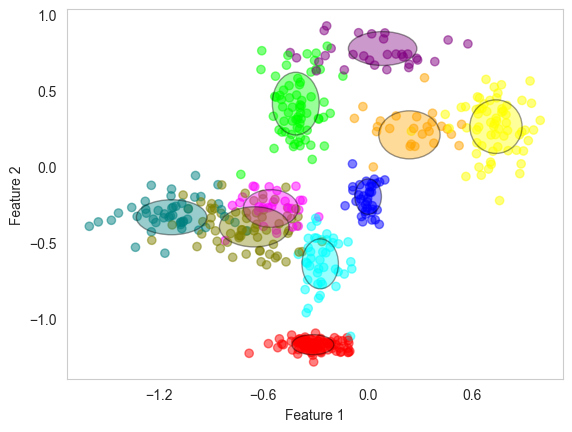

17


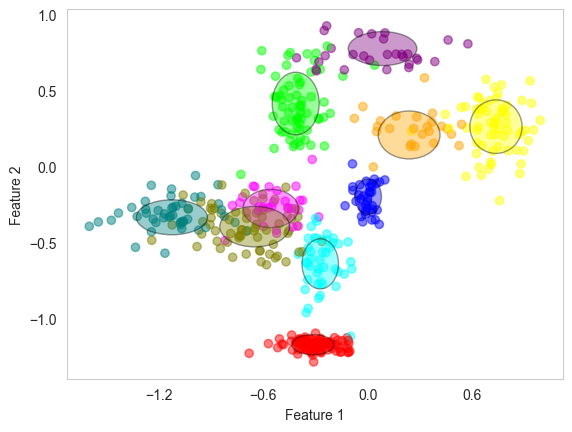

In [36]:
plt.rcParams['axes.grid'] = False

temp = np.argmax([results_vi_finite['components'][some_key]['test'] for some_key in results_em['components']])
hmm_temp = results_vi_finite['components'][13+2]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, percent=1, legend=False, title='')


temp = np.argmax([results_vi_inf['components'][some_key]['test'] for some_key in results_em['components']])
print(temp)
hmm_temp = results_vi_inf['components'][13+2]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, percent=1, legend=False, title='')


In [182]:
## infinite with merge moves

goodelbopairs_merge_kwargs = dict(
    m_startLap = 10,
    # Set limits to number of merges attempted each lap.
    # This value specifies max number of tries for each cluster
    m_maxNumPairsContainingComp = 5,
    # Set "reactivation" limits
    # So that each cluster is eligible again after 10 passes thru dataset
    # Or when it's size changes by 400%
    m_nLapToReactivate = 10,
    m_minPercChangeInNumAtomsToReactivate = 400 * 0.01,
    # Specify how to rank pairs (determines order in which merges are tried)
    # 'obsmodel_elbo' means rank pairs by improvement to observation model ELBO
    m_pair_ranking_procedure = 'obsmodel_elbo',
    m_pair_ranking_direction = 'descending',
    )

init_kwargs = dict(
    K=40,
    initname='randexamples',
    )

alg_kwargs = dict(
    nLap=100,
    nTask=1, nBatch=1, convergeThr=0.0001,
    )

hdphmm_kwargs = dict(
    startAlpha = 2,       # top-level Dirichlet concentration parameter
    transAlpha = 0.5,  # trans-level Dirichlet concentration parameter
    hmmKappa = 10,
    gamma=10
    )

gauss_kwargs = dict(
    sF = 1,          # Set prior so E[covariance] = identity
    ECovMat = 'eye',
    )

# run VI on infinite HMM

aic_inf_merge = []
bic_inf_merge = []
lls_inf_merge = []
lls_elbo_inf_merge = []

best_ll = None
best_model = None
best_elbo = None
best_model_info = None
all_elbos = []
all_ks = []
# print('calculating for n: ', n)
for cv_index in range(len(hmm_data['train_data'])):
    curr_train = hmm_data['train_data'][cv_index]
    curr_train_GroupXData = get_GroupXData_from_list(curr_train)
    curr_val = hmm_data['val_data'][cv_index]
    for i in [0,2]:
        goodelbopairs_trained_model, goodelbopairs_info_dict = bnpy.run(
            curr_train_GroupXData, 'HDPHMM', 'DiagGauss', 'memoVB',
            output_path='/tmp/mocap6/trymerge-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye-merge_strategy=good_elbo_pairs/',
            moves='merge,shuffle',
            **dict(
                sum(map(list,   [alg_kwargs.items(),
                                init_kwargs.items(),
                                hdphmm_kwargs.items(),
                                gauss_kwargs.items(),
                                goodelbopairs_merge_kwargs.items()]),[])))

        elbo = goodelbopairs_info_dict['loss']
        # all_elbos.append(elbo)
        # all_ks.append(goodelbopairs_trained_model.obsModel.K)
        # curr_hmm = get_hmm_learn_from_bnpy(goodelbopairs_trained_model)
        # score = curr_hmm.score(np.concatenate(curr_val))
        if not best_elbo or elbo < best_elbo:
            # best_ll = score
            best_model = goodelbopairs_trained_model
            best_model_info = goodelbopairs_info_dict
# aic_inf_merge.append(best_model.aic(np.concatenate(curr_test)))
# bic_inf_merge.append(best_model.bic(np.concatenate(curr_test)))
# lls_inf_merge.append(best_model.score(np.concatenate(curr_test)))
# lls_elbo_inf_merge.append(best_elbo)


Dataset Summary:
GroupXData
  total size: 12 units
  batch size: 12 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 4 
  beta = [ 2  2] 
  Expectations
  E[  mean[k]] = 
  [ 0  0]
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]]
Initialization:
  initname = randexamples
  K = 40 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/trymerge-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye-merge_strategy=good_elbo_pairs/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    1.000/100 after      0 sec. |    873.1 MiB | K   40 | loss  1.311616063e+00 |  
MERGE @ lap 2.00: Disabled. Waiting for lap >= 10 (--m_startLap).
    2.000/100 after      1 sec. |    874.4 MiB | K   40 | loss  9.8037

/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount


MERGE @ lap 11.00 : 7/39 accepted. Ndiff 0.00. 37 skipped.
   11.000/100 after     16 sec. |    886.3 MiB | K   24 | loss  8.736031850e-02 | Ndiff   20.117 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount


MERGE @ lap 12.00 : 5/35 accepted. Ndiff 0.00. 24 skipped.
   12.000/100 after     20 sec. |    886.3 MiB | K   19 | loss  8.471635388e-02 | Ndiff   20.117 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount


MERGE @ lap 13.00 : 3/28 accepted. Ndiff 0.00. 18 skipped.
   13.000/100 after     23 sec. |    886.3 MiB | K   16 | loss  8.251404285e-02 | Ndiff   20.117 
MERGE @ lap 14.00 : 0/33 accepted. Ndiff 0.00. 0 skipped.
   14.000/100 after     25 sec. |    886.3 MiB | K   16 | loss  8.201871324e-02 | Ndiff    4.545 
MERGE @ lap 15.00 : 0/29 accepted. Ndiff 0.00. 0 skipped.
   15.000/100 after     28 sec. |    886.3 MiB | K   16 | loss  8.185434734e-02 | Ndiff    2.735 
MERGE @ lap 16.00 : 0/15 accepted. Ndiff 0.00. 0 skipped.
   16.000/100 after     29 sec. |    886.3 MiB | K   16 | loss  8.175234572e-02 | Ndiff    1.466 
MERGE @ lap 17.00: No promising candidates, so no attempts.
   17.000/100 after     29 sec. |    886.3 MiB | K   16 | loss  8.166990434e-02 | Ndiff    0.808 
MERGE @ lap 18.00: No promising candidates, so no attempts.
   18.000/100 after     29 sec. |    886.3 MiB | K   16 | loss  8.166641740e-02 | Ndiff    0.490 
MERGE @ lap 19.00: No promising candidates, so no attempts.

/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount


MERGE @ lap 11.00 : 7/39 accepted. Ndiff 0.00. 37 skipped.
   11.000/100 after     16 sec. |    892.5 MiB | K   24 | loss  8.736031850e-02 | Ndiff   20.117 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount


MERGE @ lap 12.00 : 5/35 accepted. Ndiff 0.00. 24 skipped.
   12.000/100 after     21 sec. |    892.5 MiB | K   19 | loss  8.471635388e-02 | Ndiff   20.117 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount


MERGE @ lap 13.00 : 3/28 accepted. Ndiff 0.00. 18 skipped.
   13.000/100 after     24 sec. |    892.5 MiB | K   16 | loss  8.251404285e-02 | Ndiff   20.117 
MERGE @ lap 14.00 : 0/33 accepted. Ndiff 0.00. 0 skipped.
   14.000/100 after     27 sec. |    892.5 MiB | K   16 | loss  8.201871324e-02 | Ndiff    4.545 
MERGE @ lap 15.00 : 0/29 accepted. Ndiff 0.00. 0 skipped.
   15.000/100 after     29 sec. |    892.5 MiB | K   16 | loss  8.185434734e-02 | Ndiff    2.735 
MERGE @ lap 16.00 : 0/15 accepted. Ndiff 0.00. 0 skipped.
   16.000/100 after     31 sec. |    892.5 MiB | K   16 | loss  8.175234572e-02 | Ndiff    1.466 
MERGE @ lap 17.00: No promising candidates, so no attempts.
   17.000/100 after     31 sec. |    892.5 MiB | K   16 | loss  8.166990434e-02 | Ndiff    0.808 
MERGE @ lap 18.00: No promising candidates, so no attempts.
   18.000/100 after     31 sec. |    892.5 MiB | K   16 | loss  8.166641740e-02 | Ndiff    0.490 
MERGE @ lap 19.00: No promising candidates, so no attempts.

/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount


MERGE @ lap 11.00 : 7/40 accepted. Ndiff 0.00. 32 skipped.
   11.000/100 after     16 sec. |    898.6 MiB | K   22 | loss  1.020636416e-01 | Ndiff   25.276 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount


MERGE @ lap 12.00 : 3/34 accepted. Ndiff 0.00. 19 skipped.
   12.000/100 after     20 sec. |    898.6 MiB | K   19 | loss  9.990045758e-02 | Ndiff   25.276 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount


MERGE @ lap 13.00 : 4/24 accepted. Ndiff 0.00. 20 skipped.
   13.000/100 after     22 sec. |    898.6 MiB | K   15 | loss  9.838578375e-02 | Ndiff   25.276 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount


MERGE @ lap 14.00 : 2/18 accepted. Ndiff 0.00. 13 skipped.
   14.000/100 after     24 sec. |    898.6 MiB | K   13 | loss  9.727809841e-02 | Ndiff   25.276 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount


MERGE @ lap 15.00 : 0/24 accepted. Ndiff 0.00. 0 skipped.
   15.000/100 after     26 sec. |    898.6 MiB | K   13 | loss  9.707999003e-02 | Ndiff    2.302 
MERGE @ lap 16.00 : 0/14 accepted. Ndiff 0.00. 0 skipped.
   16.000/100 after     27 sec. |    898.6 MiB | K   13 | loss  9.696227658e-02 | Ndiff    1.505 
MERGE @ lap 17.00 : 0/4 accepted. Ndiff 0.00. 0 skipped.
   17.000/100 after     27 sec. |    898.6 MiB | K   13 | loss  9.686547552e-02 | Ndiff    1.458 
MERGE @ lap 18.00: No promising candidates, so no attempts.
   18.000/100 after     27 sec. |    898.6 MiB | K   13 | loss  9.679155239e-02 | Ndiff    1.139 
MERGE @ lap 19.00: No promising candidates, so no attempts.
   19.000/100 after     27 sec. |    898.6 MiB | K   13 | loss  9.678768352e-02 | Ndiff    0.955 
MERGE @ lap 20.00 : 0/2 accepted. Ndiff 0.00. 0 skipped.
   20.000/100 after     28 sec. |    898.6 MiB | K   13 | loss  9.678492593e-02 | Ndiff    0.805 
MERGE @ lap 21.00: No promising candidates, so no attempts.
  

/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount


MERGE @ lap 11.00 : 7/40 accepted. Ndiff 0.00. 32 skipped.
   11.000/100 after     16 sec. |    904.9 MiB | K   22 | loss  1.020636416e-01 | Ndiff   25.276 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount


MERGE @ lap 12.00 : 3/34 accepted. Ndiff 0.00. 19 skipped.
   12.000/100 after     20 sec. |    904.9 MiB | K   19 | loss  9.990045758e-02 | Ndiff   25.276 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount


MERGE @ lap 13.00 : 4/24 accepted. Ndiff 0.00. 20 skipped.
   13.000/100 after     22 sec. |    904.9 MiB | K   15 | loss  9.838578375e-02 | Ndiff   25.276 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: invalid value encountered in double_scalars
  latestMinCount
/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount


MERGE @ lap 14.00 : 2/18 accepted. Ndiff 0.00. 13 skipped.
   14.000/100 after     24 sec. |    904.9 MiB | K   13 | loss  9.727809841e-02 | Ndiff   25.276 


/Users/david/Documents/mastersCode/bnpy/bnpy/bnpy/mergemove/MPlanner.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  latestMinCount


MERGE @ lap 15.00 : 0/24 accepted. Ndiff 0.00. 0 skipped.
   15.000/100 after     26 sec. |    904.9 MiB | K   13 | loss  9.707999003e-02 | Ndiff    2.302 
MERGE @ lap 16.00 : 0/14 accepted. Ndiff 0.00. 0 skipped.
   16.000/100 after     27 sec. |    904.9 MiB | K   13 | loss  9.696227658e-02 | Ndiff    1.505 
MERGE @ lap 17.00 : 0/4 accepted. Ndiff 0.00. 0 skipped.
   17.000/100 after     27 sec. |    904.9 MiB | K   13 | loss  9.686547552e-02 | Ndiff    1.458 
MERGE @ lap 18.00: No promising candidates, so no attempts.
   18.000/100 after     27 sec. |    904.9 MiB | K   13 | loss  9.679155239e-02 | Ndiff    1.139 
MERGE @ lap 19.00: No promising candidates, so no attempts.
   19.000/100 after     27 sec. |    904.9 MiB | K   13 | loss  9.678768352e-02 | Ndiff    0.955 
MERGE @ lap 20.00 : 0/2 accepted. Ndiff 0.00. 0 skipped.
   20.000/100 after     28 sec. |    904.9 MiB | K   13 | loss  9.678492593e-02 | Ndiff    0.805 
MERGE @ lap 21.00: No promising candidates, so no attempts.
  

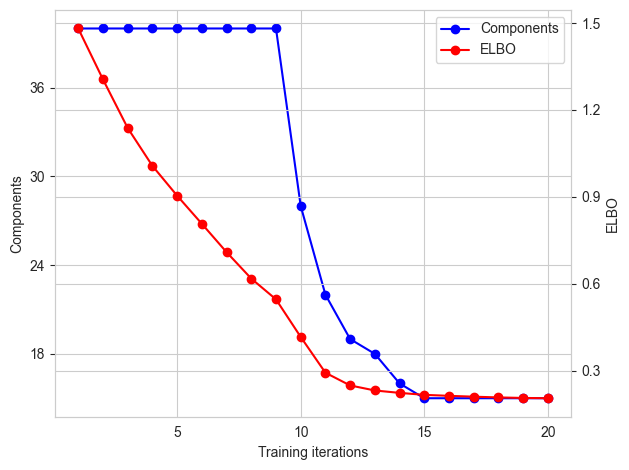

In [22]:
# plt.plot(np.arange(len(all_ks)), all_ks)
its_cutoff = 20
k_history = best_model_info['K_history'][:its_cutoff]
loss_history = best_model_info['loss_history'][:its_cutoff]
laps = best_model_info['lap_history'][:its_cutoff]
# run VI on infinite HMM, plot ELBO and amount of components,

fig, ax = plt.subplots()
# ln1 = ax.plot(ns, aic_inf, label="AIC", color="blue", marker="o")
# # ln12 = ax.plot(ns, aic_em, label="AIC", color="darkblue", marker="o")
# ln2 = ax.plot(ns, bic_inf, label="BIC", color="green", marker="o")
# ln22 = ax.plot(ns, bic_em, label="BIC", color="darkgreen", marker="o")
ax.plot(laps, k_history, label="Components", color="blue", marker="o")
ax2 = ax.twinx()
ax2.plot(laps, loss_history, label="ELBO", color="red", marker="o")
# # ln5 = ax2.plot(ns, lls_em, label="LL", color="pink", marker="o")
# ax3 = ax.twinx()
# ln4 = ax3.plot(ns, lls_elbo_inf, label="elbo", color="red", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
# ax.set_title("Infinite HMM VI Merge")
ax.set_ylabel("Components")
ax2.set_ylabel("ELBO")
ax.set_xlabel("Training iterations")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()

In [205]:
# temp = np.argmax([results_vi_inf['components'][some_key]['test'] for some_key in results_em['components']])
# print(temp)
curr_hmm = get_hmm_learn_from_bnpy(best_model)
# curr_hmm
# hmm_temp = results_vi_inf['components'][13+2]['models'][0]
plot_hmm.plot_hmm_data(data_temp, curr_hmm.predict(data_temp), curr_hmm.n_components, curr_hmm.means_, curr_hmm.covars_, feature_a=0, feature_b=1, percent=1, legend=False, title='')

AttributeError: 'numpy.int64' object has no attribute 'obsModel'